In [274]:
# Import necessary libraries
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [275]:
# Load the training data
train_data = pd.read_csv('data/train_energy.csv')

# Convert DateTime column to datetime type
train_data['DateTime'] = pd.to_datetime(train_data['DateTime'])

# Display the first few rows of the training data
train_data.head()

,DateTime,EnergyConsumption(kWh)
0,2015-11-01 00:00:00,15
1,2015-11-01 01:00:00,13
2,2015-11-01 02:00:00,10
3,2015-11-01 03:00:00,7
4,2015-11-01 04:00:00,9


In [276]:
# Feature engineering: Add additional features
train_data['hour'] = train_data['DateTime'].dt.hour
train_data['day_of_week'] = train_data['DateTime'].dt.dayofweek
train_data['month'] = train_data['DateTime'].dt.month

In [277]:
# Preprocess the data for Prophet
# Rename columns to 'ds' for DateTime and 'y' for the target variable
train_data.rename(columns={'DateTime': 'ds', 'EnergyConsumption(kWh)': 'y'}, inplace=True)

# Split the data into training and validation sets based on time
cutoff_date = '2016-12-01'  # Example cutoff date
train = train_data[train_data['ds'] < cutoff_date]
val = train_data[train_data['ds'] >= cutoff_date]

print('Training set:', train.shape)
print('Validation set:', val.shape)


Training set: (9504, 5)
Validation set: (745, 5)


In [278]:
# # Define the hyperparameter grid
# param_grid = {
#     'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
#     'seasonality_prior_scale': [0.1, 1.0, 10.0, 20.0]
# }

# # Function to perform cross-validation and calculate RMSE
# def cross_validate_prophet(train, val, param_grid):
#     best_params = None
#     best_rmse = float('inf')
    
#     for cps in param_grid['changepoint_prior_scale']:
#         for sps in param_grid['seasonality_prior_scale']:
#             # Initialize the Prophet model with the current hyperparameters
#             model = Prophet(
#                 changepoint_prior_scale=cps,
#                 seasonality_prior_scale=sps,
#                 yearly_seasonality=True,
#                 weekly_seasonality=True,
#                 daily_seasonality=True
#             )
            
#             # Fit the model on the training data
#             model.fit(train)
            
#             # Make predictions on the validation set
#             val_forecast = model.predict(val)
            
#             # Calculate RMSE on the validation set
#             rmse = np.sqrt(mean_squared_error(val['y'], val_forecast['yhat']))
            
#             # Update best parameters if current RMSE is lower
#             if rmse < best_rmse:
#                 best_rmse = rmse
#                 best_params = {'changepoint_prior_scale': cps, 'seasonality_prior_scale': sps}
    
#     return best_params, best_rmse

# # Perform cross-validation to find the best hyperparameters
# best_params, best_rmse = cross_validate_prophet(train, val, param_grid)
# print(f'Best Parameters: {best_params}')
# print(f'Best Validation RMSE: {best_rmse}')

In [279]:
# Initialize the Prophet model
# model = Prophet()

# Initialize the Prophet model with tuned hyperparameters
# model = Prophet(
#     changepoint_prior_scale=best_params['changepoint_prior_scale'],
#     seasonality_prior_scale=best_params['seasonality_prior_scale'],
#     yearly_seasonality=True,
#     weekly_seasonality=True,
#     daily_seasonality=True
# )
model = Prophet(
    changepoint_prior_scale=0.001,
    seasonality_prior_scale=0.1,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True
)

# Add additional regressors
model.add_regressor('hour')
model.add_regressor('day_of_week')
model.add_regressor('month')

# Fit the model on the training data
model.fit(train)

04:23:13 - cmdstanpy - INFO - Chain [1] start processing
04:23:13 - cmdstanpy - INFO - Chain [1] done processing


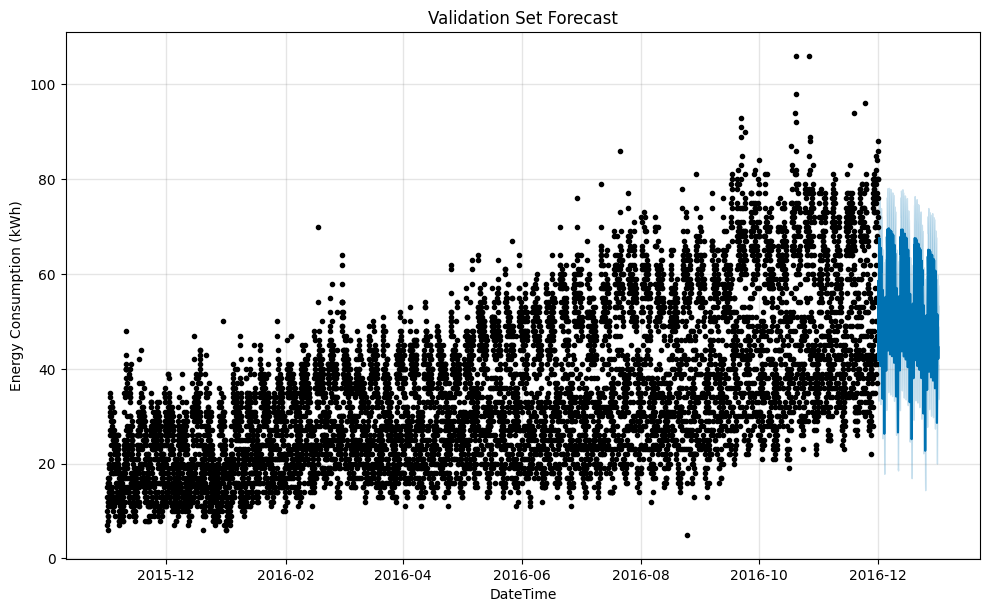

Validation RMSE: 9.392496311752966


In [280]:
# Validate the model on the validation set
val_forecast = model.predict(val)

# Visualize the forecast on the validation set
fig = model.plot(val_forecast)
plt.title('Validation Set Forecast')
plt.xlabel('DateTime')
plt.ylabel('Energy Consumption (kWh)')
plt.show()

# Calculate RMSE on the validation set
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(val['y'], val_forecast['yhat']))
print(f'Validation RMSE: {rmse}')

In [281]:
# Load the test data
test_data = pd.read_csv('data/test_energy.csv')

# Convert DateTime column to datetime type
test_data['DateTime'] = pd.to_datetime(test_data['DateTime'])

# Feature engineering: Add additional features
test_data['hour'] = test_data['DateTime'].dt.hour
test_data['day_of_week'] = test_data['DateTime'].dt.dayofweek
test_data['month'] = test_data['DateTime'].dt.month

# Preprocess the test data
# Rename the 'DateTime' column to 'ds'
test_data.rename(columns={'DateTime': 'ds'}, inplace=True)

# Make predictions on the test data
forecast = model.predict(test_data)

In [282]:
# Prepare the submission file
# Create a DataFrame with 'DateTime' and predicted 'EnergyConsumption(kWh)'
submission = test_data[['ds']].copy()
submission['EnergyConsumption(kWh)'] = forecast['yhat']
submission.rename(columns={'ds': 'DateTime'}, inplace=True)

# Save the submission file
submission.to_csv('prophet_submission.csv', index=False)

# Display the first few rows of the submission file
print(submission.head())

             DateTime  EnergyConsumption(kWh)
0 2017-01-01 01:00:00               39.753997
1 2017-01-01 02:00:00               34.983535
2 2017-01-01 03:00:00               31.098328
3 2017-01-01 04:00:00               28.554019
4 2017-01-01 05:00:00               27.425994
